-0.09706626816763125 * I(0) + 0.17141282644776926 * Z(0) + 0.1714128264477692 * Z(1) + -0.22343153690813433 * Z(2) + -0.22343153690813433 * Z(3) + 0.16868898170361205 * (Z(0) @ Z(1)) + 0.12062523483390411 * (Z(0) @ Z(2)) + 0.16592785033770338 * (Z(0) @ Z(3)) + 0.16592785033770338 * (Z(1) @ Z(2)) + 0.12062523483390411 * (Z(1) @ Z(3)) + 0.17441287612261575 * (Z(2) @ Z(3)) + -0.04530261550379926 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04530261550379926 * (X(0) @ Y(1) @ Y(2) @ X(3)) + 0.04530261550379926 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04530261550379926 * (Y(0) @ Y(1) @ X(2) @ X(3))


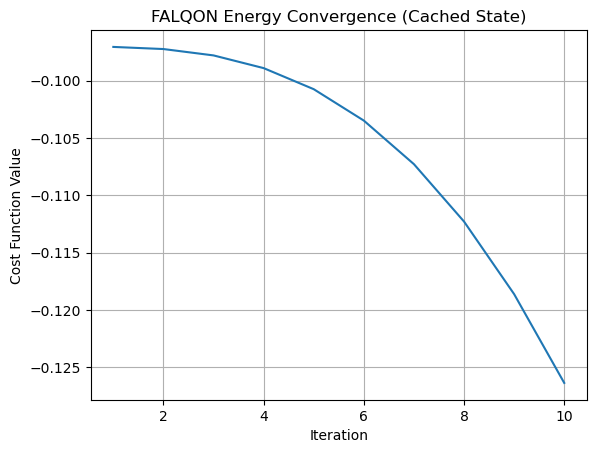

In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecular_hamiltonian
from pennylane import commutator
from scipy.linalg import expm
import matplotlib.pyplot as plt

# ========== 1. ÂàÜÂ≠êËÆæÁΩÆ ==========
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
import matplotlib.pyplot as plt

import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
import matplotlib.pyplot as plt

# 1. ËÆæÁΩÆÂàÜÂ≠êÁªìÊûÑ
from pennylane.qchem import molecular_hamiltonian

from pyscf import gto, scf
from openfermionpyscf import run_pyscf
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator
import scipy

from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

# Step 1: ÊûÑÈÄ† OpenFermion ÂàÜÂ≠êÂØπË±°Ôºà‰∏çË¶ÅÁî® PySCF ÁöÑ gto.MoleÔºâ
geometry = [('H', (0.0, 0.0, 0.0)),
            ('H', (0.0, 0.0, 0.74))]  # Âçï‰Ωç‰∏∫ √Ö
basis = 'sto-3g'
multiplicity = 1
charge = 0

molecule = MolecularData(
    geometry=geometry,
    basis=basis,
    multiplicity=multiplicity,
    charge=charge
)

# Step 2: ËøêË°å PySCF ËÆ°ÁÆóÔºàRHF + ÂìàÂØÜÈ°øÈáèÔºâ
molecule = run_pyscf(molecule, run_scf=True)

# Step 3: Jordan-Wigner ÂèòÊç¢‰∏∫ Qubit Hamiltonian
fermionic_hamiltonian = molecule.get_molecular_hamiltonian()
qubit_hamiltonian = jordan_wigner(fermionic_hamiltonian)

# Step 4: ËΩ¨Êç¢‰∏∫Á®ÄÁñèÁü©ÈòµÔºàÂ¶ÇÈúÄÁü©ÈòµÂΩ¢ÂºèÊºîÂåñÔºâ
from pennylane import PauliX, PauliY, PauliZ, Identity, Hamiltonian

def openfermion_to_qml_hamiltonian(qubit_op, n_qubits):
    coeffs = []
    ops = []
    for term, coef in qubit_op.terms.items():
        if len(term) == 0:
            ops.append(Identity(0))
        else:
            op_list = []
            for qubit_idx, pauli in term:
                if pauli == 'X':
                    op_list.append(PauliX(qubit_idx))
                elif pauli == 'Y':
                    op_list.append(PauliY(qubit_idx))
                elif pauli == 'Z':
                    op_list.append(PauliZ(qubit_idx))
            op = op_list[0] if len(op_list) == 1 else qml.prod(*op_list)
            ops.append(op)
        coeffs.append(np.real(coef))  # Âè™‰øùÁïôÂÆûÈÉ®
    return Hamiltonian(coeffs, ops)

# Ë∞ÉÁî®ËΩ¨Êç¢ÂáΩÊï∞
n_qubits = molecule.n_qubits
cost_h = openfermion_to_qml_hamiltonian(qubit_hamiltonian, n_qubits)

print(cost_h)

def decompose_pauli_rot(theta, pauli_string, wires):
    # 1. Basis changeÔºöÂ∞ÜÈùûZÁöÑÊ≥°Âà©Èó®ÊóãËΩ¨Âà∞ZÂü∫
    for p, w in zip(pauli_string, wires):
        if p == "X":
            qml.Hadamard(wires=w)
        elif p == "Y":
            qml.RX(-np.pi/2, wires=w)
        # Z Âíå I ‰∏çÈúÄË¶ÅÂèòÊç¢

    # 2. Áî® CNOT ÈìæÂè†Âä† Z ‚äó Z ‚äó ... ÁªìÊûÑ
    for i in range(len(wires) - 1):
        qml.CNOT(wires=[wires[i], wires[i+1]])

    # 3. ÊâßË°å Z ËΩ¥ÊóãËΩ¨
    qml.RZ(2 * theta, wires=wires[-1])

    # 4. ËøòÂéü CNOT Èìæ
    for i in reversed(range(len(wires) - 1)):
        qml.CNOT(wires=[wires[i], wires[i+1]])

    # 5. Basis unchangeÔºöÂèòÊç¢ÂõûÂéª
    for p, w in zip(pauli_string, wires):
        if p == "X":
            qml.Hadamard(wires=w)
        elif p == "Y":
            qml.RX(np.pi/2, wires=w)

def build_driver_h(n):
    return qml.Hamiltonian([1.0] * n, [qml.PauliX(i) for i in range(n)])

driver_h = build_driver_h(n_qubits)

def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []
    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()
    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue
                comm_terms.append(1j * c1 * c2 * comm)
            except:
                continue
    return sum(comm_terms).simplify()

comm_h = build_commutator_hamiltonian(driver_h, cost_h)

# ========== 2. Ansatz ÂíåÊµãÈáèÁîµË∑Ø ==========
def extract_ops_recursive(op):
    """ÈÄíÂΩíÊèêÂèñÊúÄÂ∫ïÂ±Ç PauliX/Y/Z/Identity Êìç‰Ωú"""
    if hasattr(op, "operands"):  # ÊòØ Prod Á≠âÂ§çÂêàÊìç‰Ωú
        ops = []
        for sub_op in op.operands:
            ops.extend(extract_ops_recursive(sub_op))
        return ops
    else:
        return [op]

def op_to_pauli_string_and_wires(op):
    """ÊûÑÂª∫ PauliRot ÊâÄÈúÄÁöÑ (pauli_word, wires)ÔºåÊîØÊåÅ‰ªªÊÑèÂµåÂ•ó Prod"""
    valid = {"PauliX": "X", "PauliY": "Y", "PauliZ": "Z", "Identity": "I"}
    ops = extract_ops_recursive(op)

    pauli_word = ""
    wires = []

    for sub_op in ops:
        if sub_op.name not in valid:
            raise ValueError(f"Unsupported sub-op: {sub_op.name}")
        pauli_word += valid[sub_op.name]
        wires.append(sub_op.wires[0])

    return pauli_word, wires


def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    for c, op in zip(cost_h.coeffs, cost_h.ops):
        pauli_word, wires = op_to_pauli_string_and_wires(op)
        if len(wires) <= 2:
            qml.PauliRot(2 * c * delta_t, pauli_word, wires=wires)
        else:
            decompose_pauli_rot(c * delta_t, pauli_word, wires)

    for c, op in zip(driver_h.coeffs, driver_h.ops):
        pauli_word, wires = op_to_pauli_string_and_wires(op)
        if len(wires) <= 2:
            qml.PauliRot(2 * c * beta_k * delta_t, pauli_word, wires=wires)
        else:
            decompose_pauli_rot(c * beta_k * delta_t, pauli_word, wires)



def build_falqon_ansatz(cost_h, driver_h, delta_t):
    def ansatz(beta, **kwargs):
        for w in dev.wires:
            qml.Hadamard(wires=w)
        for k in range(len(beta)):
            falqon_layer(beta[k], cost_h, driver_h, delta_t)
    return ansatz

def expval_circuit(beta, measurement_h):
    ansatz = build_falqon_ansatz(cost_h, driver_h, delta_t)
    ansatz(beta)
    return qml.expval(measurement_h)

# ========== 3. Ê†∏ÂøÉÔºöÁä∂ÊÄÅÁºìÂ≠òÊñπÂºèÂÆûÁé∞ FALQON ==========
from scipy.linalg import expm

def evolve(state, hamiltonian, delta_t):
    H_mat = qml.matrix(hamiltonian, wire_order=range(n_qubits))
    U = expm(-1j * delta_t * H_mat)
    return U @ state

def measure(state, hamiltonian):
    H_mat = qml.matrix(hamiltonian, wire_order=range(n_qubits))
    return np.real(np.vdot(state, H_mat @ state))

def falqon_state_cached(n, beta_1, delta_t):
    dim = 2 ** n_qubits
    state = np.ones(dim) / np.sqrt(dim)  # ÂàùÂßã |+>^n ÊÄÅ

    beta = [beta_1]
    energies = []

    for i in range(n):
        state = evolve(state, cost_h, delta_t)
        state = evolve(state, driver_h, delta_t * beta[-1])

        # ËÆ°ÁÆó comm ÂìàÂØÜÈ°øÈáèÊúüÊúõÂÄºÔºåÂæóÂà∞ beta_k+1
        beta_k1 = -measure(state, comm_h)

        # ‰∏ã‰∏ÄËΩÆÁî®Êñ∞ÁöÑ beta
        beta.append(beta_k1)

        # ËÆ°ÁÆó cost energy
        energy = measure(state, cost_h)
        energies.append(energy)

        #print(f"Á¨¨ {i+1} Ê≠•: Œ≤ = {beta_k1:.6f}, E = {energy:.8f} Ha")

    return beta, energies

# ========== 4. ËøêË°å ==========
n = 10
beta_1 = 0.0
delta_t = 0.03


dev = qml.device("default.qubit", wires=n_qubits)

# ‚úÖ ‰øùÁïôÂéüÁªìÊûÑÁöÑ cost_fnÔºà‰ªçÂèØÁî®‰∫éÈ™åËØÅÔºâ
cost_fn = qml.QNode(expval_circuit, dev, interface="autograd")

# ËøêË°å‰∏ªËøáÁ®ã
res_beta, res_energies = falqon_state_cached(n, beta_1, delta_t)
#print(qml.draw(transpiled_qnode)(res_beta[:2]))

from pennylane.transforms import transpile
coupling_map = [(0, 1), (1, 2), (2, 3)]
ansatz = build_falqon_ansatz(cost_h, driver_h, delta_t)
transpiled_ansatz = transpile(ansatz, coupling_map=coupling_map)

@qml.qnode(dev)
def transpiled_qnode(beta):
    transpiled_ansatz(beta)
    return qml.expval(cost_h)
transpiled_qnode = qml.QNode(transpiled_ansatz, dev)
#print(qml.draw(transpiled_qnode)(res_beta[:2]))




# ========== 5. ÂèØËßÜÂåñ ==========
plt.plot(range(1, n+1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.title("FALQON Energy Convergence (Cached State)")
plt.grid(True)
plt.show()



In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecular_hamiltonian
from pennylane import commutator
from scipy.linalg import expm
import matplotlib.pyplot as plt

# ========== 1. ÂàÜÂ≠êËÆæÁΩÆ ==========
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
import matplotlib.pyplot as plt

import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
import matplotlib.pyplot as plt

# 1. ËÆæÁΩÆÂàÜÂ≠êÁªìÊûÑ
from pennylane.qchem import molecular_hamiltonian

from pyscf import gto, scf
from openfermionpyscf import run_pyscf
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator
import scipy

from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

# Step 1: ÊûÑÈÄ† OpenFermion ÂàÜÂ≠êÂØπË±°Ôºà‰∏çË¶ÅÁî® PySCF ÁöÑ gto.MoleÔºâ
geometry = [('H', (0.0, 0.0, 0.0)),
            ('H', (0.0, 0.0, 0.74))]  # Âçï‰Ωç‰∏∫ √Ö
basis = 'sto-3g'
multiplicity = 1
charge = 0

molecule = MolecularData(
    geometry=geometry,
    basis=basis,
    multiplicity=multiplicity,
    charge=charge
)

# Step 2: ËøêË°å PySCF ËÆ°ÁÆóÔºàRHF + ÂìàÂØÜÈ°øÈáèÔºâ
molecule = run_pyscf(molecule, run_scf=True)

# Step 3: Jordan-Wigner ÂèòÊç¢‰∏∫ Qubit Hamiltonian
fermionic_hamiltonian = molecule.get_molecular_hamiltonian()
qubit_hamiltonian = jordan_wigner(fermionic_hamiltonian)

# Step 4: ËΩ¨Êç¢‰∏∫Á®ÄÁñèÁü©ÈòµÔºàÂ¶ÇÈúÄÁü©ÈòµÂΩ¢ÂºèÊºîÂåñÔºâ
from pennylane import PauliX, PauliY, PauliZ, Identity, Hamiltonian

def openfermion_to_qml_hamiltonian(qubit_op, n_qubits):
    coeffs = []
    ops = []
    for term, coef in qubit_op.terms.items():
        if len(term) == 0:
            ops.append(Identity(0))
        else:
            op_list = []
            for qubit_idx, pauli in term:
                if pauli == 'X':
                    op_list.append(PauliX(qubit_idx))
                elif pauli == 'Y':
                    op_list.append(PauliY(qubit_idx))
                elif pauli == 'Z':
                    op_list.append(PauliZ(qubit_idx))
            op = op_list[0] if len(op_list) == 1 else qml.prod(*op_list)
            ops.append(op)
        coeffs.append(np.real(coef))  # Âè™‰øùÁïôÂÆûÈÉ®
    return Hamiltonian(coeffs, ops)

# Ë∞ÉÁî®ËΩ¨Êç¢ÂáΩÊï∞
n_qubits = molecule.n_qubits
cost_h = openfermion_to_qml_hamiltonian(qubit_hamiltonian, n_qubits)

print(cost_h)

def decompose_pauli_rot(theta, pauli_string, wires):
    # 1. Basis changeÔºöÂ∞ÜÈùûZÁöÑÊ≥°Âà©Èó®ÊóãËΩ¨Âà∞ZÂü∫
    for p, w in zip(pauli_string, wires):
        if p == "X":
            qml.Hadamard(wires=w)
        elif p == "Y":
            qml.RX(-np.pi/2, wires=w)
        # Z Âíå I ‰∏çÈúÄË¶ÅÂèòÊç¢

    # 2. Áî® CNOT ÈìæÂè†Âä† Z ‚äó Z ‚äó ... ÁªìÊûÑ
    for i in range(len(wires) - 1):
        qml.CNOT(wires=[wires[i], wires[i+1]])

    # 3. ÊâßË°å Z ËΩ¥ÊóãËΩ¨
    qml.RZ(2 * theta, wires=wires[-1])

    # 4. ËøòÂéü CNOT Èìæ
    for i in reversed(range(len(wires) - 1)):
        qml.CNOT(wires=[wires[i], wires[i+1]])

    # 5. Basis unchangeÔºöÂèòÊç¢ÂõûÂéª
    for p, w in zip(pauli_string, wires):
        if p == "X":
            qml.Hadamard(wires=w)
        elif p == "Y":
            qml.RX(np.pi/2, wires=w)

def build_driver_h(n):
    return qml.Hamiltonian([1.0] * n, [qml.PauliX(i) for i in range(n)])

driver_h = build_driver_h(n_qubits)

def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []
    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()
    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue
                comm_terms.append(1j * c1 * c2 * comm)
            except:
                continue
    return sum(comm_terms).simplify()

comm_h = build_commutator_hamiltonian(driver_h, cost_h)

# ========== 2. Ansatz ÂíåÊµãÈáèÁîµË∑Ø ==========
def extract_ops_recursive(op):
    """ÈÄíÂΩíÊèêÂèñÊúÄÂ∫ïÂ±Ç PauliX/Y/Z/Identity Êìç‰Ωú"""
    if hasattr(op, "operands"):  # ÊòØ Prod Á≠âÂ§çÂêàÊìç‰Ωú
        ops = []
        for sub_op in op.operands:
            ops.extend(extract_ops_recursive(sub_op))
        return ops
    else:
        return [op]

def op_to_pauli_string_and_wires(op):
    """ÊûÑÂª∫ PauliRot ÊâÄÈúÄÁöÑ (pauli_word, wires)ÔºåÊîØÊåÅ‰ªªÊÑèÂµåÂ•ó Prod"""
    valid = {"PauliX": "X", "PauliY": "Y", "PauliZ": "Z", "Identity": "I"}
    ops = extract_ops_recursive(op)

    pauli_word = ""
    wires = []

    for sub_op in ops:
        if sub_op.name not in valid:
            raise ValueError(f"Unsupported sub-op: {sub_op.name}")
        pauli_word += valid[sub_op.name]
        wires.append(sub_op.wires[0])

    return pauli_word, wires


def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    for c, op in zip(cost_h.coeffs, cost_h.ops):
        pauli_word, wires = op_to_pauli_string_and_wires(op)
        if len(wires) <= 2:
            qml.PauliRot(2 * c * delta_t, pauli_word, wires=wires)
        else:
            decompose_pauli_rot(c * delta_t, pauli_word, wires)

    for c, op in zip(driver_h.coeffs, driver_h.ops):
        pauli_word, wires = op_to_pauli_string_and_wires(op)
        if len(wires) <= 2:
            qml.PauliRot(2 * c * beta_k * delta_t, pauli_word, wires=wires)
        else:
            decompose_pauli_rot(c * beta_k * delta_t, pauli_word, wires)



def build_falqon_ansatz(cost_h, driver_h, delta_t):
    def ansatz(beta, **kwargs):
        for w in dev.wires:
            qml.Hadamard(wires=w)
        for k in range(len(beta)):
            falqon_layer(beta[k], cost_h, driver_h, delta_t)
    return ansatz

def expval_circuit(beta, measurement_h):
    ansatz = build_falqon_ansatz(cost_h, driver_h, delta_t)
    ansatz(beta)
    return qml.expval(measurement_h)

# ========== 3. Ê†∏ÂøÉÔºöÁä∂ÊÄÅÁºìÂ≠òÊñπÂºèÂÆûÁé∞ FALQON ==========
from scipy.linalg import expm

def evolve(state, hamiltonian, delta_t):
    H_mat = qml.matrix(hamiltonian, wire_order=range(n_qubits))
    U = expm(-1j * delta_t * H_mat)
    return U @ state

def measure(state, hamiltonian):
    H_mat = qml.matrix(hamiltonian, wire_order=range(n_qubits))
    return np.real(np.vdot(state, H_mat @ state))

def falqon_state_cached(n, beta_1, delta_t):
    dim = 2 ** n_qubits
    state = np.ones(dim) / np.sqrt(dim)  # ÂàùÂßã |+>^n ÊÄÅ

    beta = [beta_1]
    energies = []

    for i in range(n):
        state = evolve(state, cost_h, delta_t)
        state = evolve(state, driver_h, delta_t * beta[-1])

        # ËÆ°ÁÆó comm ÂìàÂØÜÈ°øÈáèÊúüÊúõÂÄºÔºåÂæóÂà∞ beta_k+1
        beta_k1 = -measure(state, comm_h)

        # ‰∏ã‰∏ÄËΩÆÁî®Êñ∞ÁöÑ beta
        beta.append(beta_k1)

        # ËÆ°ÁÆó cost energy
        energy = measure(state, cost_h)
        energies.append(energy)

        #print(f"Á¨¨ {i+1} Ê≠•: Œ≤ = {beta_k1:.6f}, E = {energy:.8f} Ha")

    return beta, energies

# ========== 4. ËøêË°å ==========
n = 10
beta_1 = 0.0
delta_t = 0.03


dev = qml.device("default.qubit", wires=n_qubits)

# ‚úÖ ‰øùÁïôÂéüÁªìÊûÑÁöÑ cost_fnÔºà‰ªçÂèØÁî®‰∫éÈ™åËØÅÔºâ
cost_fn = qml.QNode(expval_circuit, dev, interface="autograd")

# ËøêË°å‰∏ªËøáÁ®ã
res_beta, res_energies = falqon_state_cached(n, beta_1, delta_t)
#print(qml.draw(transpiled_qnode)(res_beta[:2]))

from pennylane.transforms import transpile
coupling_map = [(0, 1), (1, 2), (2, 3)]
ansatz = build_falqon_ansatz(cost_h, driver_h, delta_t)
transpiled_ansatz = transpile(ansatz, coupling_map=coupling_map)

@qml.qnode(dev)
def transpiled_qnode(beta):
    transpiled_ansatz(beta)
    return qml.expval(cost_h)
transpiled_qnode = qml.QNode(transpiled_ansatz, dev)
#print(qml.draw(transpiled_qnode)(res_beta[:2]))




# ========== 5. ÂèØËßÜÂåñ ==========
plt.plot(range(1, n+1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.title("FALQON Energy Convergence (Cached State)")
plt.grid(True)
plt.show()



Á¨¨ 1 Ê≠•: Œ≤ = -0.055569, E = -0.09706627 Ha
Á¨¨ 2 Ê≠•: Œ≤ = -0.111077, E = -0.09725145 Ha
Á¨¨ 3 Ê≠•: Œ≤ = -0.166435, E = -0.09780615 Ha
Á¨¨ 4 Ê≠•: Œ≤ = -0.221512, E = -0.09891258 Ha
Á¨¨ 5 Ê≠•: Œ≤ = -0.276120, E = -0.10074882 Ha
Á¨¨ 6 Ê≠•: Œ≤ = -0.330002, E = -0.10348583 Ha
Á¨¨ 7 Ê≠•: Œ≤ = -0.382828, E = -0.10728331 Ha
Á¨¨ 8 Ê≠•: Œ≤ = -0.434182, E = -0.11228435 Ha
Á¨¨ 9 Ê≠•: Œ≤ = -0.483568, E = -0.11860894 Ha
Á¨¨ 10 Ê≠•: Œ≤ = -0.530418, E = -0.12634664 Ha
Á¨¨ 11 Ê≠•: Œ≤ = -0.574104, E = -0.13554894 Ha
Á¨¨ 12 Ê≠•: Œ≤ = -0.613969, E = -0.14622220 Ha
Á¨¨ 13 Ê≠•: Œ≤ = -0.649359, E = -0.15832209 Ha
Á¨¨ 14 Ê≠•: Œ≤ = -0.679671, E = -0.17175079 Ha
Á¨¨ 15 Ê≠•: Œ≤ = -0.704396, E = -0.18635785 Ha
Á¨¨ 16 Ê≠•: Œ≤ = -0.723167, E = -0.20194544 Ha
Á¨¨ 17 Ê≠•: Œ≤ = -0.735797, E = -0.21827801 Ha
Á¨¨ 18 Ê≠•: Œ≤ = -0.742302, E = -0.23509561 Ha
Á¨¨ 19 Ê≠•: Œ≤ = -0.742910, E = -0.25212956 Ha
Á¨¨ 20 Ê≠•: Œ≤ = -0.738044, E = -0.26911869 Ha
Á¨¨ 21 Ê≠•: Œ≤ = -0.728296, E = -0.28582390 Ha
Á¨¨ 22 Ê≠•: Œ≤ = -0.71

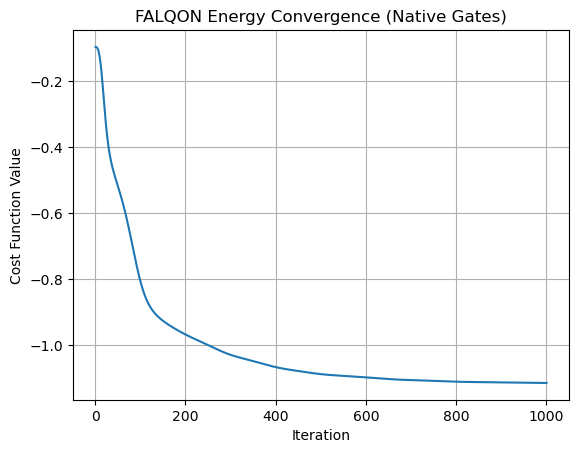

In [5]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
import matplotlib.pyplot as plt

from pyscf import gto, scf
from openfermionpyscf import run_pyscf
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator
from openfermion import MolecularData
from pennylane import PauliX, PauliY, PauliZ, Identity, Hamiltonian
from scipy.linalg import expm

geometry = [('H', (0.0, 0.0, 0.0)),
            ('H', (0.0, 0.0, 0.74))]
basis = 'sto-3g'
multiplicity = 1
charge = 0

molecule = MolecularData(geometry, basis, multiplicity, charge)
molecule = run_pyscf(molecule, run_scf=True)
fermionic_hamiltonian = molecule.get_molecular_hamiltonian()
qubit_hamiltonian = jordan_wigner(fermionic_hamiltonian)

def openfermion_to_qml_hamiltonian(qubit_op, n_qubits):
    coeffs = []
    ops = []
    for term, coef in qubit_op.terms.items():
        if len(term) == 0:
            ops.append(Identity(0))
        else:
            op_list = []
            for qubit_idx, pauli in term:
                if pauli == 'X':
                    op_list.append(PauliX(qubit_idx))
                elif pauli == 'Y':
                    op_list.append(PauliY(qubit_idx))
                elif pauli == 'Z':
                    op_list.append(PauliZ(qubit_idx))
            op = op_list[0] if len(op_list) == 1 else qml.prod(*op_list)
            ops.append(op)
        coeffs.append(np.real(coef))
    return Hamiltonian(coeffs, ops)

n_qubits = molecule.n_qubits
cost_h = openfermion_to_qml_hamiltonian(qubit_hamiltonian, n_qubits)

def build_driver_h(n):
    return qml.Hamiltonian([1.0] * n, [qml.PauliX(i) for i in range(n)])

driver_h = build_driver_h(n_qubits)

def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []
    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()
    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue
                comm_terms.append(1j * c1 * c2 * comm)
            except:
                continue
    return sum(comm_terms).simplify()

comm_h = build_commutator_hamiltonian(driver_h, cost_h)

def apply_basis_change(pauli, wire):
    if pauli == "X":
        qml.RZ(np.pi / 2, wires=wire)
        qml.SX(wires=wire)
        qml.RZ(np.pi, wires=wire)
    elif pauli == "Y":
        qml.RX(-np.pi / 2, wires=wire)
    elif pauli == "Z":
        pass

def undo_basis_change(pauli, wire):
    if pauli == "X":
        qml.RZ(-np.pi, wires=wire)
        qml.SX(wires=wire)
        qml.RZ(-np.pi / 2, wires=wire)
    elif pauli == "Y":
        qml.RX(np.pi / 2, wires=wire)
    elif pauli == "Z":
        pass

def decompose_pauli_rot_native(theta, pauli_string, wires):
    for p, w in zip(pauli_string, wires):
        apply_basis_change(p, w)

    for i in range(len(wires) - 1):
        qml.CZ(wires=[wires[i], wires[i+1]])

    qml.RZ(2 * theta, wires=wires[-1])

    for i in reversed(range(len(wires) - 1)):
        qml.CZ(wires=[wires[i], wires[i+1]])

    for p, w in zip(pauli_string, wires):
        undo_basis_change(p, w)

def extract_ops_recursive(op):
    if hasattr(op, "operands"):
        ops = []
        for sub_op in op.operands:
            ops.extend(extract_ops_recursive(sub_op))
        return ops
    else:
        return [op]

def op_to_pauli_string_and_wires(op):
    valid = {"PauliX": "X", "PauliY": "Y", "PauliZ": "Z", "Identity": "I"}
    ops = extract_ops_recursive(op)

    pauli_word = ""
    wires = []

    for sub_op in ops:
        if sub_op.name not in valid:
            raise ValueError(f"Unsupported sub-op: {sub_op.name}")
        pauli_word += valid[sub_op.name]
        wires.append(sub_op.wires[0])

    return pauli_word, wires

def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    for c, op in zip(cost_h.coeffs, cost_h.ops):
        pauli_word, wires = op_to_pauli_string_and_wires(op)
        decompose_pauli_rot_native(c * delta_t, pauli_word, wires)

    for c, op in zip(driver_h.coeffs, driver_h.ops):
        pauli_word, wires = op_to_pauli_string_and_wires(op)
        decompose_pauli_rot_native(c * beta_k * delta_t, pauli_word, wires)

def build_falqon_ansatz(cost_h, driver_h, delta_t):
    def ansatz(beta, **kwargs):
        for w in dev.wires:
            qml.Hadamard(wires=w)
        for k in range(len(beta)):
            falqon_layer(beta[k], cost_h, driver_h, delta_t)
    return ansatz

def expval_circuit(beta, measurement_h):
    ansatz = build_falqon_ansatz(cost_h, driver_h, delta_t)
    ansatz(beta)
    return qml.expval(measurement_h)

def evolve(state, hamiltonian, delta_t):
    H_mat = qml.matrix(hamiltonian, wire_order=range(n_qubits))
    U = expm(-1j * delta_t * H_mat)
    return U @ state

def measure(state, hamiltonian):
    H_mat = qml.matrix(hamiltonian, wire_order=range(n_qubits))
    return np.real(np.vdot(state, H_mat @ state))

def falqon_state_cached(n, beta_1, delta_t):
    dim = 2 ** n_qubits
    state = np.ones(dim) / np.sqrt(dim)

    beta = [beta_1]
    energies = []

    for i in range(n):
        state = evolve(state, cost_h, delta_t)
        state = evolve(state, driver_h, delta_t * beta[-1])
        beta_k1 = -measure(state, comm_h)
        beta.append(beta_k1)
        energy = measure(state, cost_h)
        energies.append(energy)
        print(f"Á¨¨ {i+1} Ê≠•: Œ≤ = {beta_k1:.6f}, E = {energy:.8f} Ha")

    return beta, energies

n = 1000
beta_1 = 0.0
delta_t = 0.03

dev = qml.device("default.qubit", wires=n_qubits)
cost_fn = qml.QNode(expval_circuit, dev, interface="autograd")
res_beta, res_energies = falqon_state_cached(n, beta_1, delta_t)
print(qml.draw(transpiled_qnode)(res_beta[:2]))
plt.plot(range(1, n+1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.title("FALQON Energy Convergence (Native Gates)")
plt.grid(True)
plt.show()


In [6]:
with qml.queuing.AnnotatedQueue() as q:
    transpiled_ansatz(res_beta[:2])  # Áî®2Â±ÇÊµãËØï

tape = qml.tape.QuantumTape.from_queue(q)

# ÊâãÂä®ÁªüËÆ°Èó®Êï∞
from collections import Counter
gate_counter = Counter(op.name for op in tape.operations)

print(gate_counter)


Counter({'RZ': 134, 'CZ': 72, 'SX': 48, 'RX': 32, 'SWAP': 12, 'Hadamard': 4})


/root/miniconda3/envs/FBQA_Hydrogen/lib/python3.10/site-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.3 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


Step 1: beta = -0.055569, energy = -0.09706627 Ha
Step 2: beta = -0.111077, energy = -0.09725145 Ha
Step 3: beta = -0.166435, energy = -0.09780615 Ha
Step 4: beta = -0.221512, energy = -0.09891258 Ha
Step 5: beta = -0.276120, energy = -0.10074882 Ha
Step 6: beta = -0.330002, energy = -0.10348583 Ha
Step 7: beta = -0.382828, energy = -0.10728331 Ha
Step 8: beta = -0.434182, energy = -0.11228435 Ha
Step 9: beta = -0.483568, energy = -0.11860894 Ha
Step 10: beta = -0.530418, energy = -0.12634664 Ha
Step 11: beta = -0.574104, energy = -0.13554894 Ha
Step 12: beta = -0.613969, energy = -0.14622220 Ha
Step 13: beta = -0.649359, energy = -0.15832209 Ha
Step 14: beta = -0.679671, energy = -0.17175079 Ha
Step 15: beta = -0.704396, energy = -0.18635785 Ha
Step 16: beta = -0.723167, energy = -0.20194544 Ha
Step 17: beta = -0.735797, energy = -0.21827801 Ha
Step 18: beta = -0.742302, energy = -0.23509561 Ha
Step 19: beta = -0.742910, energy = -0.25212956 Ha
Step 20: beta = -0.738044, energy = -0.2

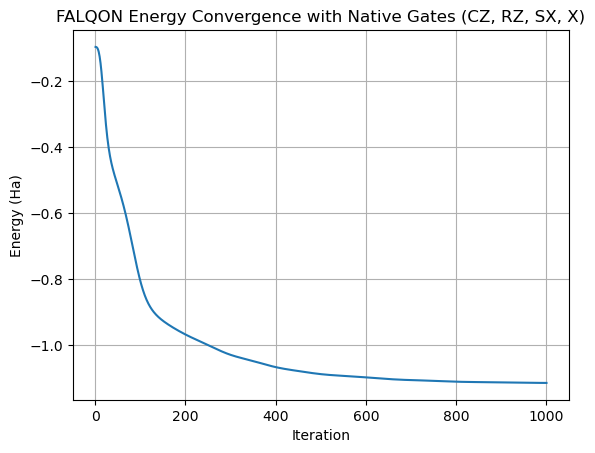

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
import matplotlib.pyplot as plt

from pyscf import gto, scf
from openfermionpyscf import run_pyscf
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator
from openfermion import MolecularData
from pennylane import PauliX, PauliY, PauliZ, Identity, Hamiltonian
from scipy.linalg import expm
from collections import Counter

# ========== Molecule Setup ==========
geometry = [('H', (0.0, 0.0, 0.0)),
            ('H', (0.0, 0.0, 0.74))]
basis = 'sto-3g'
multiplicity = 1
charge = 0

molecule = MolecularData(geometry, basis, multiplicity, charge)
molecule = run_pyscf(molecule, run_scf=True)
fermionic_hamiltonian = molecule.get_molecular_hamiltonian()
qubit_hamiltonian = jordan_wigner(fermionic_hamiltonian)

n_qubits = molecule.n_qubits

# ========== Hamiltonian Conversion ==========
def openfermion_to_qml_hamiltonian(qubit_op, n_qubits):
    coeffs = []
    ops = []
    for term, coef in qubit_op.terms.items():
        if len(term) == 0:
            ops.append(Identity(0))
        else:
            op_list = []
            for qubit_idx, pauli in term:
                if pauli == 'X':
                    op_list.append(PauliX(qubit_idx))
                elif pauli == 'Y':
                    op_list.append(PauliY(qubit_idx))
                elif pauli == 'Z':
                    op_list.append(PauliZ(qubit_idx))
            op = op_list[0] if len(op_list) == 1 else qml.prod(*op_list)
            ops.append(op)
        coeffs.append(np.real(coef))
    return Hamiltonian(coeffs, ops)

cost_h = openfermion_to_qml_hamiltonian(qubit_hamiltonian, n_qubits)

def build_driver_h(n):
    return qml.Hamiltonian([1.0] * n, [qml.PauliX(i) for i in range(n)])

driver_h = build_driver_h(n_qubits)

# ========== Commutator ==========
def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []
    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()
    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue
                comm_terms.append(1j * c1 * c2 * comm)
            except:
                continue
    return sum(comm_terms).simplify()

comm_h = build_commutator_hamiltonian(driver_h, cost_h)

# ========== Native Gate Tools ==========
def rx_with_basis(theta, w):
    qml.RZ(-np.pi / 2, wires=w)
    qml.SX(wires=w)
    qml.RZ(np.pi, wires=w)
    qml.RZ(theta, wires=w)
    qml.SX(wires=w)
    qml.RZ(-np.pi / 2, wires=w)

def hadamard_with_basis(w):
    qml.RZ(np.pi / 2, wires=w)
    qml.SX(wires=w)
    qml.RZ(np.pi, wires=w)

def apply_basis_change(p, w):
    if p == "X":
        hadamard_with_basis(w)
    elif p == "Y":
        rx_with_basis(-np.pi / 2, w)

def undo_basis_change(p, w):
    if p == "X":
        hadamard_with_basis(w)
    elif p == "Y":
        rx_with_basis(np.pi / 2, w)

def decompose_pauli_rot_native(theta, pauli_string, wires):
    for p, w in zip(pauli_string, wires):
        apply_basis_change(p, w)
    for i in range(len(wires) - 1):
        qml.CZ(wires=[wires[i], wires[i+1]])
    qml.RZ(2 * theta, wires=wires[-1])
    for i in reversed(range(len(wires) - 1)):
        qml.CZ(wires=[wires[i], wires[i+1]])
    for p, w in zip(pauli_string, wires):
        undo_basis_change(p, w)

def extract_ops_recursive(op):
    if hasattr(op, "operands"):
        ops = []
        for sub_op in op.operands:
            ops.extend(extract_ops_recursive(sub_op))
        return ops
    else:
        return [op]

def op_to_pauli_string_and_wires(op):
    valid = {"PauliX": "X", "PauliY": "Y", "PauliZ": "Z", "Identity": "I"}
    ops = extract_ops_recursive(op)
    pauli_word = ""
    wires = []
    for sub_op in ops:
        if sub_op.name not in valid:
            raise ValueError(f"Unsupported sub-op: {sub_op.name}")
        pauli_word += valid[sub_op.name]
        wires.append(sub_op.wires[0])
    return pauli_word, wires

def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    for c, op in zip(cost_h.coeffs, cost_h.ops):
        pauli_word, wires = op_to_pauli_string_and_wires(op)
        decompose_pauli_rot_native(c * delta_t, pauli_word, wires)
    for c, op in zip(driver_h.coeffs, driver_h.ops):
        pauli_word, wires = op_to_pauli_string_and_wires(op)
        decompose_pauli_rot_native(c * beta_k * delta_t, pauli_word, wires)

def build_falqon_ansatz(cost_h, driver_h, delta_t):
    def ansatz(beta, **kwargs):
        for w in range(n_qubits):
            hadamard_with_basis(w)
        for k in range(len(beta)):
            falqon_layer(beta[k], cost_h, driver_h, delta_t)
    return ansatz

def evolve(state, hamiltonian, delta_t):
    H_mat = qml.matrix(hamiltonian, wire_order=range(n_qubits))
    U = expm(-1j * delta_t * H_mat)
    return U @ state

def measure(state, hamiltonian):
    H_mat = qml.matrix(hamiltonian, wire_order=range(n_qubits))
    return np.real(np.vdot(state, H_mat @ state))

def falqon_state_cached(n, beta_1, delta_t):
    dim = 2 ** n_qubits
    state = np.ones(dim) / np.sqrt(dim)
    beta = [beta_1]
    energies = []
    for i in range(n):
        state = evolve(state, cost_h, delta_t)
        state = evolve(state, driver_h, delta_t * beta[-1])
        beta_k1 = -measure(state, comm_h)
        beta.append(beta_k1)
        energy = measure(state, cost_h)
        energies.append(energy)
        print(f"Step {i+1}: beta = {beta_k1:.6f}, energy = {energy:.8f} Ha")
    return beta, energies

n = 1000
beta_1 = 0.0
delta_t = 0.03
res_beta, res_energies = falqon_state_cached(n, beta_1, delta_t)


dev = qml.device("default.qubit", wires=n_qubits)
ansatz = build_falqon_ansatz(cost_h, driver_h, delta_t)

@qml.qnode(dev)
def transpiled_qnode(beta):
    ansatz(beta)
    return qml.expval(cost_h)

print(qml.draw(transpiled_qnode)(res_beta[:2]))

with qml.queuing.AnnotatedQueue() as q:
    ansatz(res_beta[:2])
tape = qml.tape.QuantumTape.from_queue(q)
gate_counts = Counter(op.name for op in tape.operations)
print("\nGate counts:")
for g, c in gate_counts.items():
    print(f"{g}: {c}")

plt.plot(range(1, n+1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("FALQON Energy Convergence with Native Gates (CZ, RZ, SX, X)")
plt.grid(True)
plt.show()

In [2]:
from collections import Counter
from pennylane.queuing import AnnotatedQueue
from pennylane.tape import QuantumTape

# ÊçïÊçâ ansatz ÊûÑÈÄ†ÁöÑÊìç‰ΩúÈòüÂàó
with AnnotatedQueue() as q:
    ansatz(res_beta[:2])  # ‰ΩøÁî®‰∏§Â±Ç beta

# ÊûÑÈÄ†ÈáèÂ≠ê tape
tape = QuantumTape.from_queue(q)

# ÁªüËÆ°ÊâÄÊúâÊìç‰Ωú‰∏≠ gate ÁöÑÂêçÂ≠ó
gate_counter = Counter(op.name for op in tape.operations)

# ËæìÂá∫Èó®ÁªüËÆ°ÁªìÊûú
print("Gate counts:")
for gate, count in gate_counter.items():
    print(f"{gate}: {count}")

Gate counts:
RZ: 270
SX: 116
CZ: 72


In [3]:
for op in cost_h.ops:
    
    print(op)

I(0)
Z(0)
Z(1)
Z(2)
Z(3)
Z(0) @ Z(1)
Z(0) @ Z(2)
Z(0) @ Z(3)
Z(1) @ Z(2)
Z(1) @ Z(3)
Z(2) @ Z(3)
X(0) @ X(1) @ Y(2) @ Y(3)
X(0) @ Y(1) @ Y(2) @ X(3)
Y(0) @ X(1) @ X(2) @ Y(3)
Y(0) @ Y(1) @ X(2) @ X(3)
